In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro, levene, bartlett

!pip install tbats
from tbats import TBATS, BATS


import seaborn as sns
from scipy.stats import shapiro


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.0 MB/s eta 0:00:00


Data processing

In [6]:
# import data

url = "/content/All Spreads & Inputs.csv"

df = pd.read_csv(url)

df = df[['Start_Date', 'DAM']].sort_values('Start_Date')

# set timestamp as index and convert to datetime object

df['Start_Date'] = pd.to_datetime(df['Start_Date'])
df.set_index('Start_Date', inplace=True)

# data re-sampled based on an hour
df = df.resample('H').mean()

# Fill missing values using forward fill
df['DAM'] = df['DAM'].fillna(method='ffill')

# Fill missing values using backward fill
df['DAM'] = df['DAM'].fillna(method='bfill')






Normality

Anderson-Darling test statistic: 449.336858360748
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
At the 15.0% significance level, the data does not look normal (reject H0).
At the 10.0% significance level, the data does not look normal (reject H0).
At the 5.0% significance level, the data does not look normal (reject H0).
At the 2.5% significance level, the data does not look normal (reject H0).
At the 1.0% significance level, the data does not look normal (reject H0).


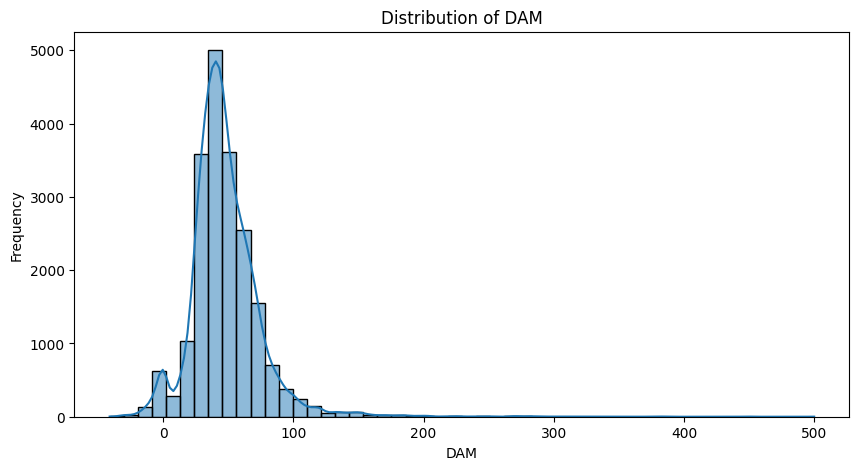

In [7]:
from scipy.stats import anderson


# Anderson-Darling test
result = anderson(df['DAM'])

print('Anderson-Darling test statistic:', result.statistic)
print('Critical values:', result.critical_values)
print('Significance levels:', result.significance_level)

# Interpretation
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f'At the {sl}% significance level, the data looks normal (fail to reject H0).')
    else:
        print(f'At the {sl}% significance level, the data does not look normal (reject H0).')

# Plot the distribution of the data
plt.figure(figsize=(10, 5))
sns.histplot(df['DAM'], kde=True, bins=50)
plt.xlabel('DAM')
plt.ylabel('Frequency')
plt.title('Distribution of DAM')
plt.show()


Seasonality decomposition

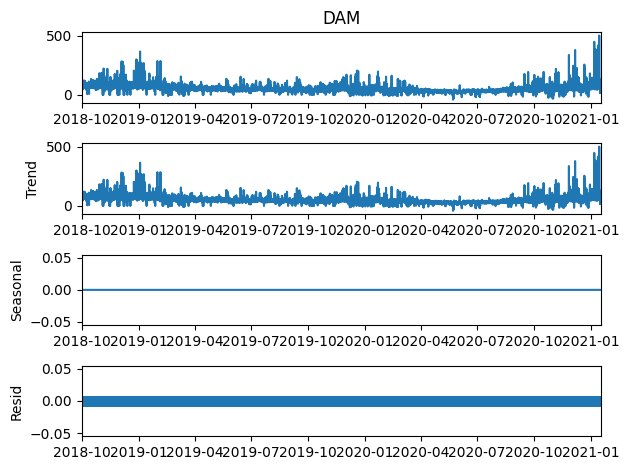

In [8]:
# Perform seasonal decomposition using the additive model
result = seasonal_decompose(df['DAM'], model='additive', period=1)

# Plot the decomposed components
result.plot()
plt.show()


Autocorrelation

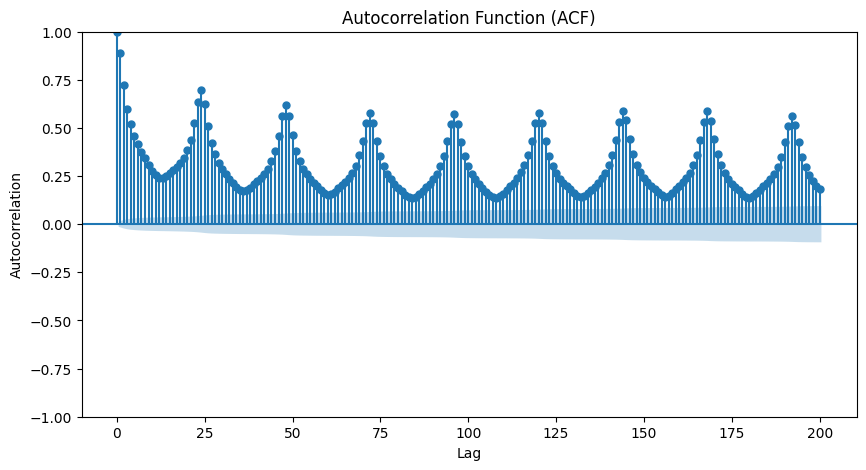

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


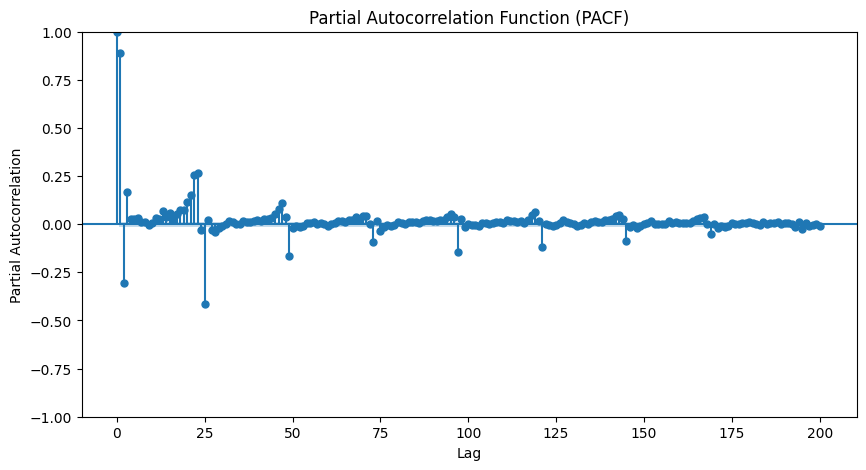

In [9]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#

# ACF plot
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df['DAM'], lags=200, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PCF 
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(df['DAM'], lags=200, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrlation Function (PACF)')
plt.show()


**Troughs and peaks observed consistently at 12 and 24 lags for n=500.**

Homoscedasticity

Levene's test statistic: 1.7171843186421445e-06
p-value: 0.9989544441552811
Bartlett's test statistic: 3.0144181634663033e-06
p-value: 0.998614707151254


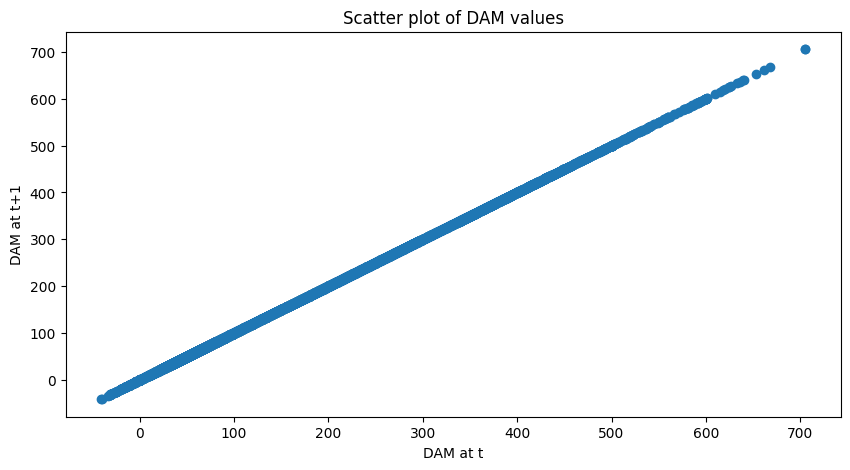

Levene's test: Fail to reject H0. The variances are equal (homoscedasticity).
Bartlett's test: Fail to reject H0. The variances are equal (homoscedasticity).


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import levene, bartlett

# Levene's test
stat, p = levene(df['DAM'], df['DAM'].shift(1).dropna())
print("Levene's test statistic:", stat)
print('p-value:', p)

# Bartlett's test
stat, p = bartlett(df['DAM'], df['DAM'].shift(1).dropna())
print("Bartlett's test statistic:", stat)
print('p-value:', p)

# Scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(df['DAM'][:-1], df['DAM'].shift(1).dropna())
plt.xlabel("DAM at t")
plt.ylabel("DAM at t+1")
plt.title("Scatter plot of DAM values")
plt.show()

# Interpretation
significance_level = 0.05

levenes_p = levene(df['DAM'], df['DAM'].shift(1).dropna())[1]
bartletts_p = bartlett(df['DAM'], df['DAM'].shift(1).dropna())[1]

if levenes_p < significance_level:
    print("Levene's test: Reject H0. The variances are not equal (heteroscedasticity).")
else:
    print("Levene's test: Fail to reject H0. The variances are equal (homoscedasticity).")

if bartletts_p < significance_level:
    print("Bartlett's test: Reject H0. The variances are not equal (heteroscedasticity).")
else:
    print("Bartlett's test: Fail to reject H0. The variances are equal (homoscedasticity).")


CONCLUSIONS

1. Multiple types of seasonality are present
2. Heteroscedasticity is not present

An xgboost model with feature engineering to derive the relevant seasonalities would produce a highly accurate model. GARCH adaptation for a forecast is not relevant for the DAM, but may be for the intraday markets.

The price distribution has very long tails, forecast error on such occasions is inevitable but may be remedied by inclusion of wind and demand forecast variables at various lags.